
Visualizing kNN for Initial_real_data...


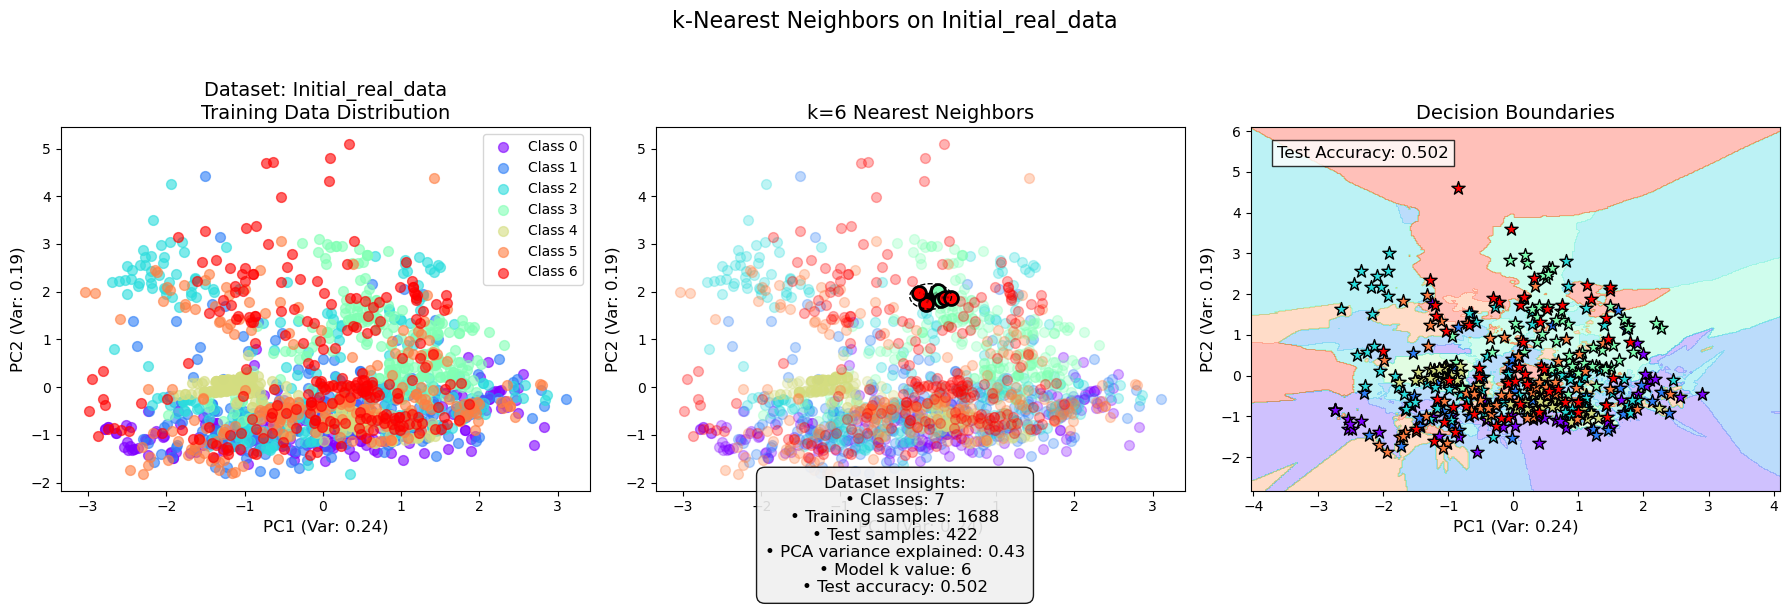


Visualizing kNN for Initial_synth_data...


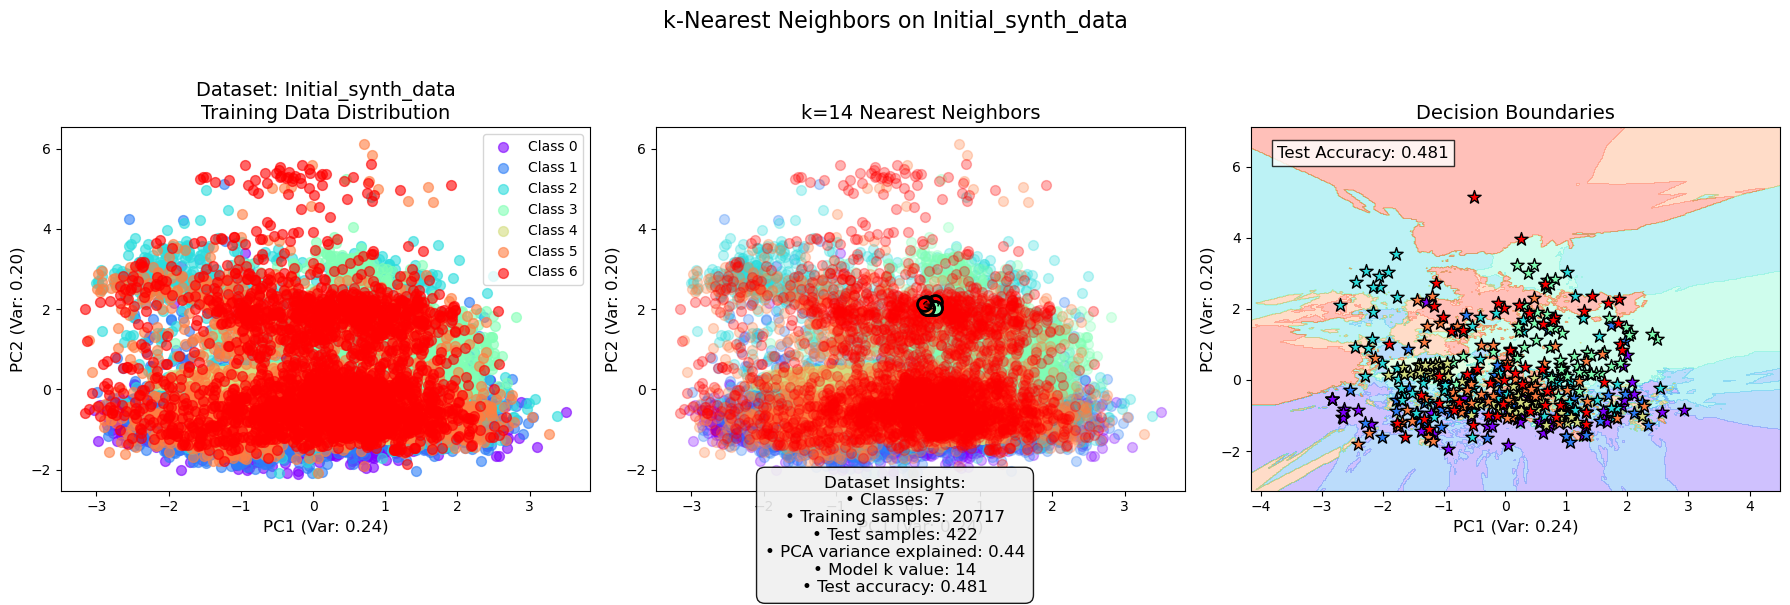


Visualizing kNN for Extra_real_data...


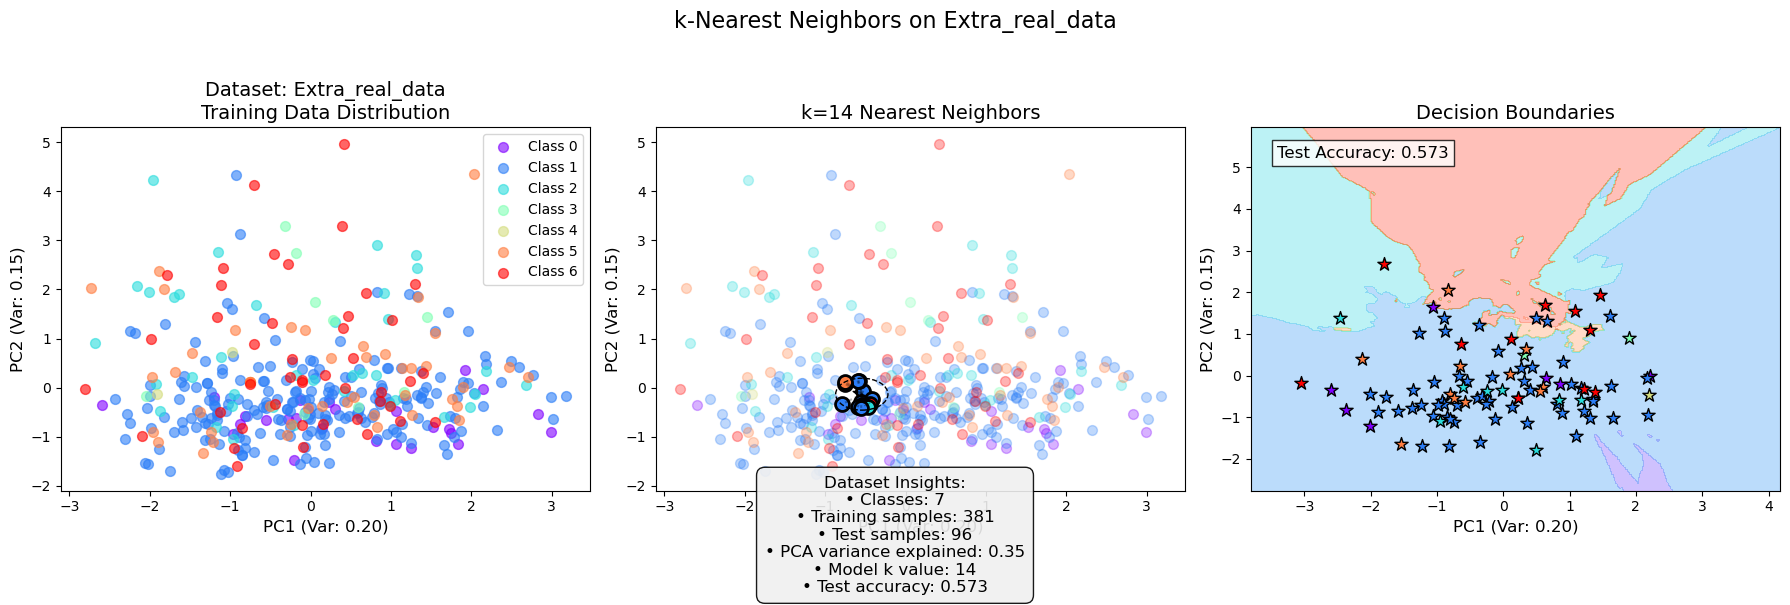


Visualizing kNN for Extra_real_pseudoreal_data...


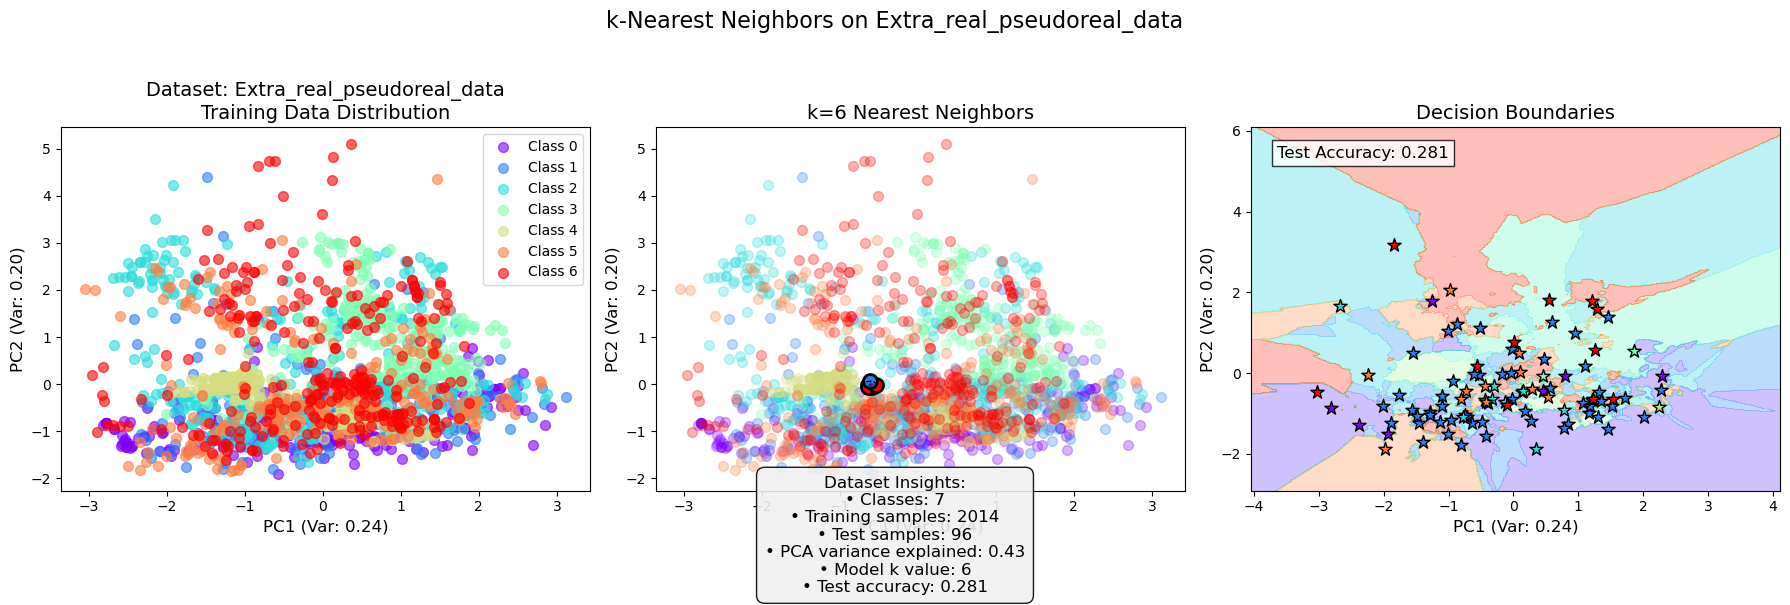


Visualizing kNN for Extra_real_pseudoreal_synth_data...


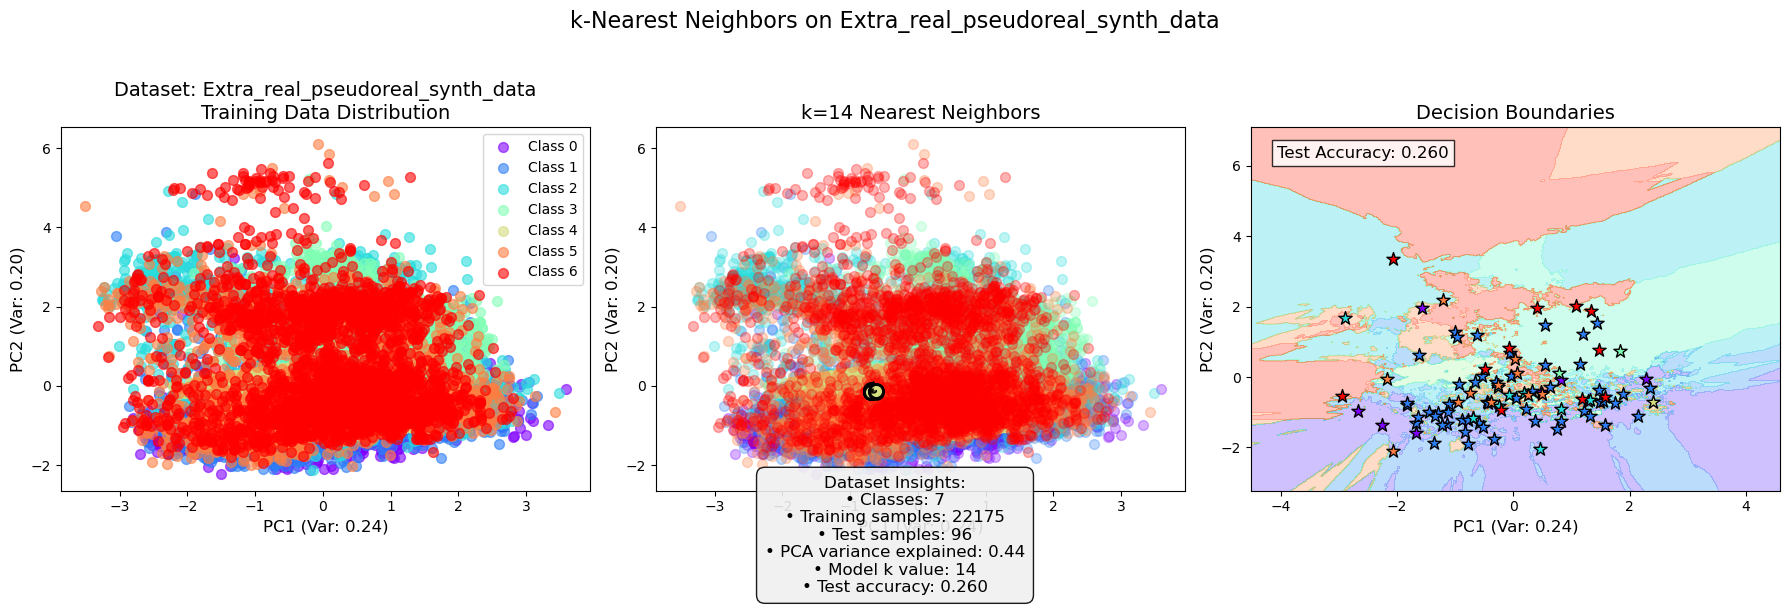

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches
from collections import Counter

# Load results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

# Get all datasets
datasets = ['Initial_real_data', 'Initial_synth_data', 'Extra_real_data', 
            'Extra_real_pseudoreal_data', 'Extra_real_pseudoreal_synth_data']
model_name = '$k$NN'

# Function to load data
def load_data(dataset_name):
    try:
        parts = dataset_name.split('_')
        approach = parts[0]
        dataset_short = "_".join(parts[1:])
        
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/y_train.csv").values.ravel()
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/y_test.csv").values.ravel()
        
        return X_train, y_train, X_test, y_test
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

def visualize_knn_for_dataset(dataset_name):
    """Visualize kNN for a specific dataset"""
    print(f"\nVisualizing kNN for {dataset_name}...")
    
    # Get model
    model = results[dataset_name][model_name]['fitted_model']
    k = model.n_neighbors
    
    # Load data
    X_train, y_train, X_test, y_test = load_data(dataset_name)
    
    if X_train is None:
        print(f"Could not load data for {dataset_name}. Skipping.")
        return
    
    # Use PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)
    X_test_2d = pca.transform(X_test)
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # Create a figure with 3 subplots to show the kNN process step by step
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. First subplot: Show the training data distribution
    ax = axes[0]
    unique_classes = np.unique(y_train)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
    
    for i, cls in enumerate(unique_classes):
        idx = y_train == cls
        ax.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], 
                  color=colors[i], label=f'Class {cls}', 
                  alpha=0.6, s=50)
    
    ax.set_title(f'Dataset: {dataset_name}\nTraining Data Distribution', fontsize=14)
    ax.set_xlabel(f'PC1 (Var: {explained_variance[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 (Var: {explained_variance[1]:.2f})', fontsize=12)
    ax.legend(loc='upper right')
    
    # 2. Second subplot: Show a new point and its neighbors
    ax = axes[1]
    
    # Plot training data again
    for i, cls in enumerate(unique_classes):
        idx = y_train == cls
        ax.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], 
                  color=colors[i], alpha=0.3, s=50)
    
    # Choose a test point to classify
    np.random.seed(42)  # For reproducibility
    test_idx = np.random.randint(0, len(X_test_2d))
    test_point = X_test_2d[test_idx]
    true_class = y_test[test_idx]
    
    # Plot the test point
    ax.scatter(test_point[0], test_point[1], color='black', 
              marker='*', s=200, label='New point')
    
    # Find k nearest neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_2d, y_train)
    distances, indices = knn.kneighbors([test_point])
    
    # Plot the k nearest neighbors
    for i, idx in enumerate(indices[0]):
        neighbor_point = X_train_2d[idx]
        neighbor_class = y_train[idx]
        
        # Draw line to neighbor
        ax.plot([test_point[0], neighbor_point[0]], 
                [test_point[1], neighbor_point[1]], 
                'k--', alpha=0.3)
        
        # Highlight neighbor
        ax.scatter(neighbor_point[0], neighbor_point[1], 
                  color=colors[neighbor_class], 
                  edgecolor='black', linewidth=2, s=100)
    
    # Draw a circle around the k nearest neighbors
    circle = plt.Circle((test_point[0], test_point[1]), 
                       distances[0][-1], fill=False, 
                       linestyle='--', color='black')
    ax.add_patch(circle)
    
    ax.set_title(f'k={k} Nearest Neighbors', fontsize=14)
    ax.set_xlabel(f'PC1 (Var: {explained_variance[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 (Var: {explained_variance[1]:.2f})', fontsize=12)
    
    # 3. Third subplot: Show the decision boundaries
    ax = axes[2]
    
    # Create a meshgrid for decision boundary
    h = 0.02  # step size in the mesh
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict on the mesh grid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.rainbow)
    
    # Plot test points
    for i, cls in enumerate(unique_classes):
        idx = y_test == cls
        ax.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], 
                  color=colors[i], marker='*', 
                  edgecolor='black', s=100)
    
    # Calculate and display accuracy
    accuracy = knn.score(X_test_2d, y_test)
    ax.text(0.05, 0.95, f"Test Accuracy: {accuracy:.3f}", 
           transform=ax.transAxes, fontsize=12, va='top',
           bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_title('Decision Boundaries', fontsize=14)
    ax.set_xlabel(f'PC1 (Var: {explained_variance[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 (Var: {explained_variance[1]:.2f})', fontsize=12)
    
    # Add overall title
    plt.suptitle(f'k-Nearest Neighbors on {dataset_name}', fontsize=16)
    
    # Add dataset-specific insights
    class_distribution = Counter(y_train)
    n_classes = len(class_distribution)
    
    insights = (
        f"Dataset Insights:\n"
        f"• Classes: {n_classes}\n"
        f"• Training samples: {len(X_train)}\n"
        f"• Test samples: {len(X_test)}\n"
        f"• PCA variance explained: {sum(explained_variance):.2f}\n"
        f"• Model k value: {k}\n"
        f"• Test accuracy: {accuracy:.3f}"
    )
    
    fig.text(0.5, 0.01, insights, ha='center', fontsize=12, 
            bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

# Visualize kNN for each dataset
for dataset in datasets:
    visualize_knn_for_dataset(dataset)


Visualizing Random Forest for Initial_real_data...


c:\Users\danii\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


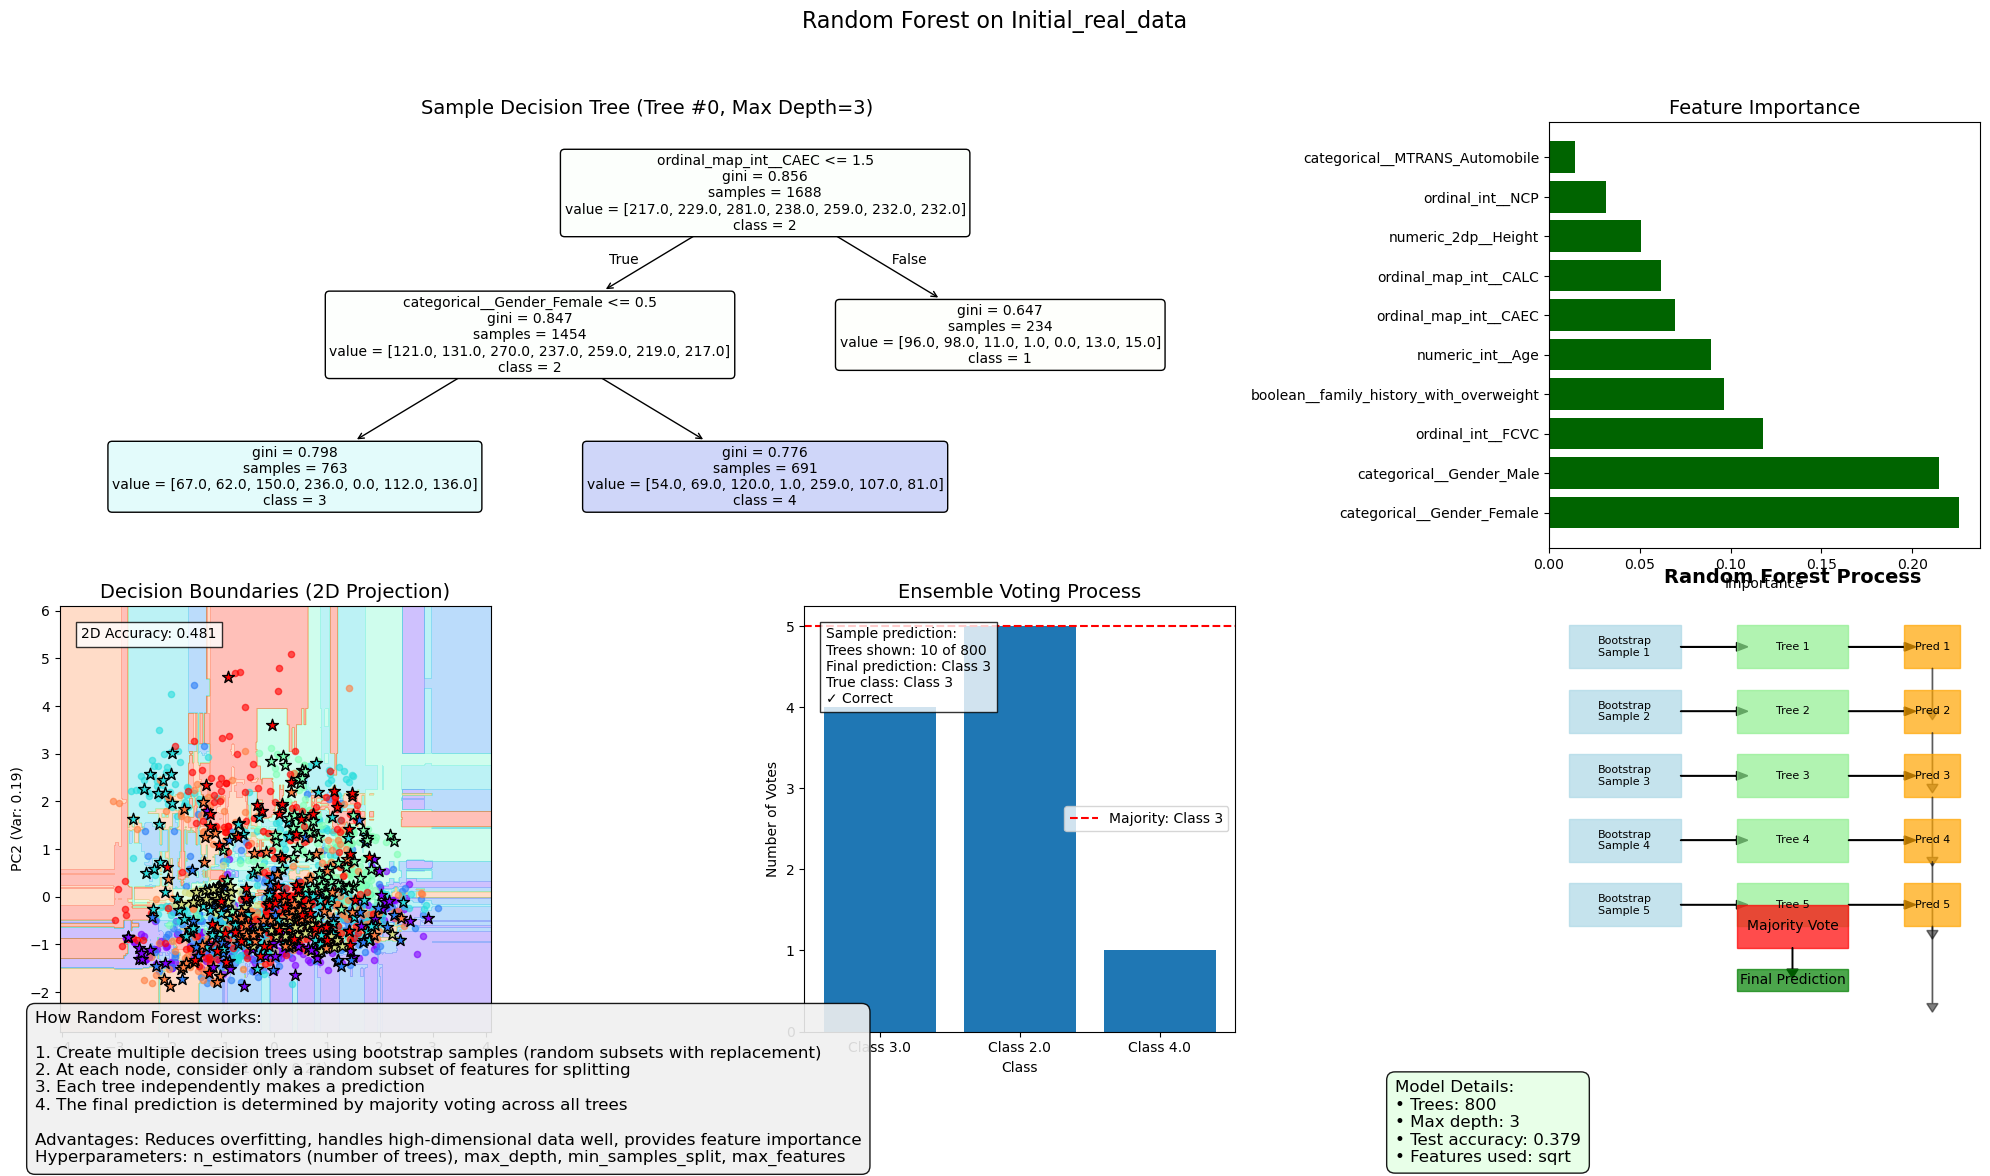

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
from collections import Counter

# Load results
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

# Function to load data
def load_data(dataset_name):
    try:
        parts = dataset_name.split('_')
        approach = parts[0]
        dataset_short = "_".join(parts[1:])
        
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/y_train.csv").values.ravel()
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset_short}/y_test.csv").values.ravel()
        
        return X_train, y_train, X_test, y_test
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

def visualize_random_forest(dataset_name):
    """Visualize Random Forest for a specific dataset"""
    print(f"\nVisualizing Random Forest for {dataset_name}...")
    
    # Get model
    model = results[dataset_name]['Random Forest']['fitted_model']
    
    # Load data
    X_train, y_train, X_test, y_test = load_data(dataset_name)
    
    if X_train is None:
        print(f"Could not load data for {dataset_name}. Skipping.")
        return
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. First subplot: Sample tree from the forest
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    
    # Get a sample tree from the forest
    tree_idx = 0  # First tree
    tree = model.estimators_[tree_idx]
    
    # Plot the tree with limited depth for visibility
    max_depth = 3
    plot_tree(tree, 
              max_depth=max_depth,
              feature_names=X_train.columns if hasattr(X_train, 'columns') else None,
              class_names=[str(i) for i in model.classes_],
              filled=True, 
              rounded=True,
              fontsize=10,
              ax=ax1)
    
    ax1.set_title(f'Sample Decision Tree (Tree #{tree_idx}, Max Depth={max_depth})', fontsize=14)
    
    # 2. Second subplot: Feature importance
    ax2 = plt.subplot2grid((2, 3), (0, 2))
    
    # Get feature importance
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot top 10 features
    top_n = min(10, len(importances))
    ax2.barh(range(top_n), importances[indices[:top_n]], color='darkgreen')
    ax2.set_yticks(range(top_n))
    ax2.set_yticklabels([feature_names[i] for i in indices[:top_n]])
    ax2.set_title('Feature Importance', fontsize=14)
    ax2.set_xlabel('Importance')
    
    # 3. Third subplot: Decision boundaries
    ax3 = plt.subplot2grid((2, 3), (1, 0))
    
    # Use PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)
    X_test_2d = pca.transform(X_test)
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # Create a meshgrid for decision boundary
    h = 0.02  # step size in the mesh
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Train a Random Forest on the 2D data for visualization
    rf_2d = RandomForestClassifier(n_estimators=10, random_state=42)
    rf_2d.fit(X_train_2d, y_train)
    
    # Predict on the mesh grid
    Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    unique_classes = np.unique(y_train)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
    
    ax3.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.rainbow)
    
    # Plot training points
    for i, cls in enumerate(unique_classes):
        idx = y_train == cls
        ax3.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], 
                   color=colors[i], alpha=0.6, s=20)
    
    # Plot test points
    for i, cls in enumerate(unique_classes):
        idx = y_test == cls
        ax3.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], 
                   color=colors[i], marker='*', 
                   edgecolor='black', s=80)
    
    # Calculate and display accuracy
    accuracy = rf_2d.score(X_test_2d, y_test)
    ax3.text(0.05, 0.95, f"2D Accuracy: {accuracy:.3f}", 
            transform=ax3.transAxes, fontsize=10, va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax3.set_title('Decision Boundaries (2D Projection)', fontsize=14)
    ax3.set_xlabel(f'PC1 (Var: {explained_variance[0]:.2f})')
    ax3.set_ylabel(f'PC2 (Var: {explained_variance[1]:.2f})')
    
    # 4. Fourth subplot: Ensemble voting process
    ax4 = plt.subplot2grid((2, 3), (1, 1))
    
    # Select a test sample
    np.random.seed(42)
    test_idx = np.random.randint(0, len(X_test))
    test_sample = X_test.iloc[test_idx] if hasattr(X_test, 'iloc') else X_test[test_idx]
    true_class = y_test[test_idx]
    
    # Get predictions from individual trees
    tree_predictions = []
    n_trees_to_show = min(10, len(model.estimators_))
    
    for i in range(n_trees_to_show):
        tree = model.estimators_[i]
        pred = tree.predict([test_sample])[0]
        tree_predictions.append(pred)
    
    # Count votes
    vote_counts = Counter(tree_predictions)
    
    # Plot the voting process
    ax4.bar(range(len(vote_counts)), 
            [vote_counts[cls] for cls in vote_counts.keys()], 
            tick_label=[f'Class {cls}' for cls in vote_counts.keys()])
    
    # Highlight the majority vote
    final_pred = model.predict([test_sample])[0]
    ax4.axhline(y=max(vote_counts.values()), color='red', linestyle='--', 
               label=f'Majority: Class {final_pred}')
    
    # Add text about the prediction
    prediction_text = (
        f"Sample prediction:\n"
        f"Trees shown: {n_trees_to_show} of {len(model.estimators_)}\n"
        f"Final prediction: Class {final_pred}\n"
        f"True class: Class {true_class}\n"
        f"{'✓ Correct' if final_pred == true_class else '✗ Incorrect'}"
    )
    ax4.text(0.05, 0.95, prediction_text, transform=ax4.transAxes, 
            fontsize=10, va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax4.set_title('Ensemble Voting Process', fontsize=14)
    ax4.set_xlabel('Class')
    ax4.set_ylabel('Number of Votes')
    ax4.legend()
    
    # 5. Fifth subplot: Random Forest diagram
    ax5 = plt.subplot2grid((2, 3), (1, 2))
    ax5.axis('off')
    
    # Draw Random Forest diagram
    ax5.text(0.5, 0.95, "Random Forest Process", fontsize=14, ha='center', weight='bold')
    
    # Draw bootstrap samples and trees
    n_trees = 5
    for i in range(n_trees):
        y_pos = 0.8 - i * 0.15
        
        # Bootstrap sample
        ax5.add_patch(plt.Rectangle((0.1, y_pos-0.05), 0.2, 0.1, fill=True, 
                                   color='lightblue', alpha=0.7))
        ax5.text(0.2, y_pos, f"Bootstrap\nSample {i+1}", ha='center', va='center', fontsize=8)
        
        # Arrow to tree
        ax5.arrow(0.3, y_pos, 0.1, 0, head_width=0.02, head_length=0.02, 
                 fc='black', ec='black')
        
        # Decision tree
        ax5.add_patch(plt.Rectangle((0.4, y_pos-0.05), 0.2, 0.1, fill=True, 
                                   color='lightgreen', alpha=0.7))
        ax5.text(0.5, y_pos, f"Tree {i+1}", ha='center', va='center', fontsize=8)
        
        # Arrow to prediction
        ax5.arrow(0.6, y_pos, 0.1, 0, head_width=0.02, head_length=0.02, 
                 fc='black', ec='black')
        
        # Prediction
        ax5.add_patch(plt.Rectangle((0.7, y_pos-0.05), 0.1, 0.1, fill=True, 
                                   color='orange', alpha=0.7))
        ax5.text(0.75, y_pos, f"Pred {i+1}", ha='center', va='center', fontsize=8)
        
        # Arrow to majority vote
        ax5.arrow(0.75, y_pos-0.05, 0, -0.1 - i*0.02, head_width=0.02, head_length=0.02, 
                 fc='black', ec='black', alpha=0.5)
    
    # Majority vote
    ax5.add_patch(plt.Rectangle((0.4, 0.1), 0.2, 0.1, fill=True, 
                               color='red', alpha=0.7))
    ax5.text(0.5, 0.15, "Majority Vote", ha='center', va='center', fontsize=10)
    
    # Final prediction
    ax5.arrow(0.5, 0.1, 0, -0.05, head_width=0.02, head_length=0.02, 
             fc='black', ec='black')
    ax5.add_patch(plt.Rectangle((0.4, 0.0), 0.2, 0.05, fill=True, 
                               color='green', alpha=0.7))
    ax5.text(0.5, 0.025, "Final Prediction", ha='center', va='center', fontsize=10)
    
    # Add overall title
    plt.suptitle(f'Random Forest on {dataset_name}', fontsize=16)
    
    # Add explanation of Random Forest
    explanation = (
        "How Random Forest works:\n\n"
        "1. Create multiple decision trees using bootstrap samples (random subsets with replacement)\n"
        "2. At each node, consider only a random subset of features for splitting\n"
        "3. Each tree independently makes a prediction\n"
        "4. The final prediction is determined by majority voting across all trees\n\n"
        "Advantages: Reduces overfitting, handles high-dimensional data well, provides feature importance\n"
        "Hyperparameters: n_estimators (number of trees), max_depth, min_samples_split, max_features"
    )
    
    # Add dataset-specific insights
    model_accuracy = model.score(X_test, y_test)
    
    insights = (
        f"Model Details:\n"
        f"• Trees: {len(model.estimators_)}\n"
        f"• Max depth: {model.max_depth if model.max_depth else 'None (unlimited)'}\n"
        f"• Test accuracy: {model_accuracy:.3f}\n"
        f"• Features used: {model.max_features if hasattr(model, 'max_features') else 'auto'}"
    )
    
    fig.text(0.02, 0.02, explanation, fontsize=12, 
            bbox=dict(facecolor='#f0f0f0', alpha=0.9, boxstyle='round,pad=0.5'))
    
    fig.text(0.7, 0.02, insights, fontsize=12, 
            bbox=dict(facecolor='#e6ffe6', alpha=0.9, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

# Choose a dataset to visualize
dataset_name = 'Initial_real_data'  # Change this to visualize different datasets
visualize_random_forest(dataset_name)

# Uncomment to visualize for all datasets
for dataset in ['Initial_real_data', 'Initial_synth_data', 'Extra_real_data', 'Extra_real_pseudoreal_data', 'Extra_real_pseudoreal_synth_data']:
visualize_random_forest(dataset)